## Installing requirements

In [1]:
! export PATH='$PATH:/home/monga/.local/lib/python3.8/site-packages'

In [2]:
#import util
from psfdataset import PSFDataset, transforms
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange

In [60]:
"""
script to compute the number
of jsons created for each
word. The output is a .csv
file where for each word the
number of jsons corresponding
to train, val, and test subsets
is mentioned
"""

import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def get_rect_and_landmarks(rect, landmarks):
    # converts and returns the face rectangle and landmarks
    # in formats appropriate for the display function

    x = rect["left"]
    y = rect["top"]
    w = rect["width"]
    h = rect["height"]

    if landmarks is not None:
        temp_agg = list()
        for i in range(len(landmarks)):
            temp = list()
            temp.append(landmarks["point-" + str(i+1)]["x"])
            temp.append(landmarks["point-" + str(i+1)]["y"])
            temp_agg.append(temp)
        return (x, y, w, h), np.asarray(temp_agg)
    else:
        return (x, y, w, h), np.empty((0, 0))


def choose_the_largest_face(faces_list):
    if len(faces_list) == 1: 
        return faces_list[0]
    
    area_max = 0
    area_max_id = 0
    for i,face in enumerate(faces_list):
        (face_rect,landmarks) = face
        area = face_rect[2] * face_rect[3] # area = width * height
        if area > area_max:
            area_max = area
            area_max_id = i
    return faces_list[area_max_id]


def load_one_json_file(filename, isDebug=False):
    # load the metadata and facial landmarks

    face_rect_list = []
    landmarks_list = []
    with open(filename) as f:
        video_data_dict = json.load(f)
        # extract duration
        if video_data_dict["metaData"] is not None:
            duration = float(re.findall(r"[-+]?\d*\.\d+|\d+", video_data_dict["metaData"]["Duration"])[0])
            if isDebug:
                print("duration metadata: %.3f" % duration)

        # extract frame information aggregated for all frames
        agg_frame_data = video_data_dict["aggFrameInfo"]  # list of frame-wise visual data

        for frame_data in agg_frame_data:
            n_faces = frame_data["numFaces"]
            if isDebug:
                print("frame index: %d number of faces: %d" % (frame_data["frameIndex"], n_faces))
            
            if frame_data["facialAttributes"] is not None:# if so, the n_faces should > 0 
                faces_list = []
                for attr in frame_data["facialAttributes"]:
                    face_idx = attr["faceIndex"]
                    face_rect, landmarks = get_rect_and_landmarks(attr["faceRectangle"],
                                                                  attr["faceLandmarks"])
                    faces_list.append((face_rect, landmarks))

                face_rect_chosen, landmarks_chosen = choose_the_largest_face(faces_list)    
                face_rect_list.append(face_rect_chosen)
                landmarks_list.append(landmarks_chosen)
    
    face_rect_array = np.array(face_rect_list)
    landmarks_array = np.array(landmarks_list)
    return face_rect_array, landmarks_array








i_data = "/cache/lrw/lipread_landmarks/dlib68_2d_sparse_json/lipread_mp4"
# or i_data = "/cache/lrw/lipread_landmarks/dlib68_2d_sparse_json_defects_not_one_face/lipread_mp4"
selected_n_classes = 10 # the max is 500

cnt = 0
data = dict()

for word in os.listdir(i_data):
    if not word.startswith('.'):
        cnt += 1
        if cnt > selected_n_classes:
            break
        print(cnt,word)
        splits = dict() # 'train' 'val' and 'test' sets
        # print("analysing data for the word: '%s'" % word)
        p = os.path.join(i_data, word)
        
        for sub_dir in os.listdir(p):
            if not sub_dir.startswith('.'):
                # print(sub_dir)
                p_sub = os.path.join(p, sub_dir)
                for _, _, files in os.walk(p_sub):
                    samples_list = []
                    for filename in files:
                        if filename.endswith('.json'):
                            face_rect_array, landmarks_array = load_one_json_file(os.path.join(p_sub, filename))
                            lip_region = []
                            for j in range(len(landmarks_array)):
                                lip_region.append(np.stack((landmarks_array[j][48],landmarks_array[j][51],landmarks_array[j][57],landmarks_array[j][54])))
                            samples_list.append(np.array(lip_region))
                    splits[sub_dir] = samples_list
        data[word] = splits

print('-------------------------------')
print(data.keys()) # names of all the 'selected_n_classes' classes  
print(data['THOUGHT'].keys()) # print the names of the 3 splits for the first class 'THOUGHT'
print(len(data['THOUGHT']['train'])) # print the number of train samples of the first class
print(data['THOUGHT']['train'][0].shape) # print the shape (29 frames, 68 landmarks, 2 coordinates) of the first training sample of the first class    
print('-------------------------------')                     
        


1 THOUGHT
2 INVOLVED
3 DIFFERENT
4 MAYBE
5 REPORT
6 VICTIMS
7 GETTING
8 UNION
9 MEDIA
10 VIOLENCE
-------------------------------
dict_keys(['THOUGHT', 'INVOLVED', 'DIFFERENT', 'MAYBE', 'REPORT', 'VICTIMS', 'GETTING', 'UNION', 'MEDIA', 'VIOLENCE'])
dict_keys(['val', 'test', 'train'])
1000
(29, 4, 2)
-------------------------------


# Step 0: Defining a LabelEncoder to transform text class to numberic class

In [61]:
encoder= LabelEncoder()
categories = list(data.keys())
encoder.fit(categories)

LabelEncoder()

# Step 1: Defining my custom Data loader from above 'data'. We only need to properly define iterators for train/test/validation sets

In [62]:
def generate_iterator(data, key = 'train', refLength = 29):
    iter_list = []
    x = 0
    for word, keypointsOneWord in data.items():
        

        keypointsList = keypointsOneWord[key]
        num_of_samples = len(keypointsList)
        
        ## There are some sample whose length is smaller than 29. We need to either delete it, 
        ## or extend it to 29 length for now. But this can be resolved if signature transform is introduced
        for i in range(len(keypointsList)):
             singleSample = keypointsList[i]
             if len(singleSample) < refLength:
                 singleSample = np.array(list(singleSample) + [singleSample[-1]] * (refLength - len(singleSample)))
                 keypointsList[i] = singleSample
        iter_list = iter_list + list(zip(keypointsList, np.array(list(encoder.transform([word])) * num_of_samples)))
    return iter(iter_list)

In [63]:
iter_train = generate_iterator(data, key = 'train')
iter_test = generate_iterator(data, key = 'test')
iter_val = generate_iterator(data, key = 'val')

In [64]:
iiter_test = [x for x in iter_test]
iiter_train = [x for x in iter_train]

# Step 2: Let's adapt the PSFDataset from human body movement

In [65]:
tr = transforms.Compose([
    #transforms.spatial.Crop(),
#     transforms.spatial.Normalize(),
#     transforms.SpatioTemporalPath(),
#     transforms.temporal.MultiDelayedTransformation(2),
    transforms.temporal.DyadicPathSignatures(dyadic_levels=2,
                                             signature_level=4)
])

As first steps, no transforms are introduced yet.

In [72]:
def average_rot(video_array):
    
    n = len(video_array)
    '''This function calculates the angle of rotation for each video in each frame. 
    The result can be used to build histograms as in the following cell. '''
    #loop over all of the video
    theta = []
    for i in range(n):
        
        a = video_array[i].copy() #i-th video
        
        #loop over all of the frames
        
        for j in range(a.shape[0]):
                                  
            a[j,:,0] = a[j,:,0] - a[j,2,0]
            a[j,:,1] = a[j,:,1] - a[j,2,1]
            
            cos = a[j,1,1]/np.sqrt(a[j,1,0]**2 + a[j,1,1]**2) #cos(theta)
            sin = a[j,1,0]/np.sqrt(a[j,1,0]**2 + a[j,1,1]**2) #sin(theta)
            
            theta.append(np.arcsin(sin))
    
    return theta

(array([2.9000e+01, 1.7200e+02, 3.0350e+03, 1.6084e+04, 9.0040e+03,
        6.5800e+02, 1.7000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-0.98279372, -0.72743472, -0.47207571, -0.21671671,  0.0386423 ,
         0.2940013 ,  0.54936031,  0.80471931,  1.06007832,  1.31543732,
         1.57079633]),
 <a list of 10 Patch objects>)

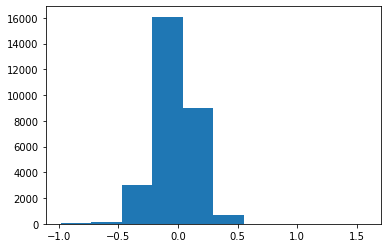

In [10]:
plt.hist(average_rot(data['THOUGHT']['train']))

In [71]:
def rotate(video_array):
    
    n = len(video_array)
    
    #loop over all of the video
    
    for i in range(n):
        
        a = video_array[i].copy() #i-th video
        
        #loop over all of the frames
        
        for j in range(a.shape[0]):
            
            """
            From now on we will work with the j-th frame of the i-th video a[j,:,:].
            
            Let us recall that the 30-th landmark is the lower extreme of the nose while 
            the 27-th landmark is the upper extreme of the nose.
            
            The main idea of this rotation function is to firstly translate all of the landmarks
            in the reference system with origin in a[j,30,:]. Afterwards, we look at a[j,27,:]
            as a vector in R^2 in this new system and we apply a rotation to all of the
            landmarks so that the first coordinate of a[j,27,:] becomes 0.
            
            This rotation can be achieved by defining an R^2 rotation matrix of angle theta (which takes the form 
            [[cos(theta), -sin(theta)], [sin(theta), cos(theta)]]) where theta is the angle between a[j,27,:]
            and the y axis.
            """
                      
            a[j,:,0] = a[j,:,0] - a[j,2,0]
            a[j,:,1] = a[j,:,1] - a[j,2,1]
            
            cos = a[j,1,1]/np.sqrt(a[j,1,0]**2 + a[j,1,1]**2) #cos(theta)
            sin = a[j,1,0]/np.sqrt(a[j,1,0]**2 + a[j,1,1]**2)
            
            
            
            for l in range(a.shape[1]):
                
                rot = np.array([[cos,-sin],[sin,cos]])
                
                a[j,l,:] = rot@a[j,l,:]
        
        
    return video_array

In [17]:
from importlib import reload
reload(util_lip)

<module 'util_lip_data' from '/scratch/cdt_miniproject_2021/xiongw/lrw_data_preprocessing/util_lip_data.py'>

In [58]:
face_rect_array, landmarks_array = load_one_json_file(os.path.join(p_sub, filename))

In [44]:
import util_lip_data as util_lip

from random import sample

key = 'DIFFERENT'
data_type = 'train'

sampled_clips = sample(data[key][data_type], 4)

util_lip.display_animation_multiple_faces(sampled_clips, word = key, transform_keypoints = True)

In [30]:
def flip_image(video_array):
    '''This functions flips the landmarks about an axis.'''
    a = video_array #i-th video
        
    b = np.copy(a)

    for j in range(a.shape[0]):

        for l in range(a.shape[1]):

            b[j,l,0] = -a[j,l,0]

    return b

In [31]:
"""
Utility functions for landmark-based human action recognition using path signatures
"""

import requests

import cv2
from moviepy.editor import VideoFileClip, clips_array
import numpy as np
from tqdm.notebook import tqdm

def download(source_url, target_filename, chunk_size=1024):
    """
    Download a file via HTTP.

    Parameters
    ----------
    source_url: str
        URL of the file to download
    target_filename: str
        Target filename
    chunk_size: int
        Chunk size
    """
    response = requests.get(source_url, stream=True)
    file_size = int(response.headers['Content-Length'])

    with open(target_filename, 'wb') as handle:
        for data in tqdm(response.iter_content(chunk_size=chunk_size),
                         total=int(file_size / chunk_size), unit='KB',
                         desc='Downloading dataset:'):
            handle.write(data)

class SkeletonFace():
    """
    Skeleton representation for visualisation and animation consisting of dots
    representing landmarks and lines representing connections.
    """

    # When transforming key points, use a fraction of the image size as a minimum of empty,
    # black region around the skeleton
    IMG_BORDER_FRAC = 0.1

    def __init__(self,
                 target_width,
                 target_height,
                 radius=10,
                 confidence_coord=None,
                 transform_keypoints=False):
        """
        Parameters
        ----------
        target_width: int
            Image width for visualisation
        target_height: int
            Image height for visualisation
        radius: int
            Landmark radius
        confidence_coord: int
            Index of confidence estimates
        draw_connections: bool
            Whether to draw connections between the key points
         transform_keypoints: bool
            Whether to transform key points
        """
        self.landmarks = [(226, 0, 255)] * 17 + [(155, 0, 255)] * 5 + [(198, 0, 255)] * 5 + [(70, 0, 255)] * 4 + \
                         [(141, 255, 0)] * 5 + [(99, 255, 0)] * 6 + [(127, 0, 255)] * 6 + [(255, 42, 0)] * 12 + \
                         [(255, 113, 0)] * 8
        
        self.radius = radius
        self.confidence_coord = confidence_coord
        self.target_width = target_width
        self.target_height = target_height
        self.transform_keypoints = transform_keypoints

    def draw(self, keypoints):

        """
        Plot a static keypoint image.

        Parameters
        ----------
        keypoints: numpy array
            Keypoints to be drawn
        """
        img = np.zeros((self.target_height, self.target_width, 3), dtype=np.uint8)

        keypoints = keypoints[:, 0:2].copy()
        if self.transform_keypoints:
            keypoints = self._transform_keypoints(keypoints)

        keypoints = np.around(keypoints).astype(np.int32)

        self._draw_landmarks(keypoints, img)

        return img

    def _draw_landmarks(self, keypoints, img):
        for i, colour in enumerate(self.landmarks):
            # Skip points with confidence 0 (usually means not detected)
            if self.confidence_coord is not None and keypoints[i, self.confidence_coord] == 0:
                continue
            point = tuple(keypoints[i])
            if point[0] != 0 or point[1] != 0:
                cv2.circle(img, point[0:2], self.radius, colour, -1)

    def _transform_keypoints(self, keypoints):
        keypoints -= np.amin(keypoints, axis=0)
        keypoint_scale = np.amax(keypoints, axis=0)
        keypoints *= np.array((self.target_width, self.target_height)) * (
            1 - 2 * SkeletonFace.IMG_BORDER_FRAC) / keypoint_scale
        keypoints += np.array((self.target_width, self.target_height)) * SkeletonFace.IMG_BORDER_FRAC

        return keypoints

    def animate(self, keypoints, filename=None, fps=25, codec='XVID'):
        """
        Convert key points to a animation and output to a video file.

        Parameters
        ----------
        keypoints: numpy array
            Array of keypoints in the form [frame,landmark,coords]
        filename: string, optional (default is None)
            If given the video is saved to the specified file
        fps: float
            Number of frames per second
        codec: str
            Video codec represented in fourcc format
        """
        if filename is not None:
            fourcc = cv2.VideoWriter_fourcc(*codec)
            vid_file = cv2.VideoWriter(filename, fourcc, fps,
                                       (self.target_width, self.target_height))

        vid = np.zeros((keypoints.shape[0], self.target_height, self.target_width, 3),
                       dtype=np.uint8)

        for i in range(vid.shape[0]):
            vid[i] = self.draw(keypoints[i])
            if filename is not None:
                frame = cv2.cvtColor(vid[i], cv2.COLOR_RGB2BGR)
                vid_file.write(frame)
        if filename is not None:
            vid_file.release()

        return vid

def generate_one_clip(keypoints, clip_height=768, display_height=240,
                  temp_file='__temp__.avi', word = '', transform_keypoints = False):
    """
    Display a side-by-side animation comprising the skeleton and (optionally) the source
    video.

    Parameters
    ----------
    keypoints : numpy array
        Array of keypoints in the form [frame,landmark,coords]
    clip_height : int
        Desired clip height (applies to both source video and skeleton, the former is upscaled)
    display_height : int
        Desired display height
    temp_file : int
        Temporary file for transcoding
    include_source_video: bool
        Whether to include the source video
    word: str,
        The word that the person says
    """
    keypoints = np.copy(keypoints) 
    rescaling_factor = clip_height/display_height
    keypoints = keypoints * rescaling_factor

    #duration = 1
    skeleton = SkeletonFace(target_width=clip_height, target_height=clip_height, transform_keypoints = transform_keypoints)
    skeleton.animate(keypoints, temp_file, )#fps=len(keypoints)/duration)
    
    clip_skeleton = VideoFileClip(temp_file)
    
    return clip_skeleton

def display_animation_multiple_faces(keypoints_array, clip_height=768, display_height=240,
                      temp_file='__temp__.avi', word = '', transform_keypoints = False):
    clip_list = []
    for i, keypoints in enumerate(keypoints_array):
        clip = generate_one_clip(keypoints, clip_height = clip_height, display_height = display_height,
                                 temp_file = temp_file.replace('__.', '__{}.'.format(i)), word = word,
                                 transform_keypoints = transform_keypoints)
        clip_list.append(clip)
    clip_final = clips_array([clip_list])
    return clip_final.ipython_display(height=display_height, rd_kwargs=dict(logger=None))   

def display_animation_face(keypoints, clip_height=768, display_height=240,
                      temp_file='__temp__.avi', word = '', transform_keypoints = False):
    """
    Display a side-by-side animation comprising the skeleton and (optionally) the source
    video.

    Parameters
    ----------
    keypoints : numpy array
        Array of keypoints in the form [frame,landmark,coords]
    clip_height : int
        Desired clip height (applies to both source video and skeleton, the former is upscaled)
    display_height : int
        Desired display height
    temp_file : int
        Temporary file for transcoding
    include_source_video: bool
        Whether to include the source video
    word: str,
        The word that the person says
    """

    if len(word) > 0:
        print(word)
    clip = generate_one_clip(keypoints, clip_height = clip_height, display_height = display_height,
                             temp_file = temp_file, word = word, 
                             transform_keypoints = transform_keypoints)

    return clip.ipython_display(height=display_height, rd_kwargs=dict(logger=None))


In [32]:
# Training set augmentation 

def flip_train_augmentation(video_data): 
    '''The function returns a dictionary equal to the raw data, but the training set 
    for each word in the dictionary is augmented with its flipped version.'''
    modified_data = video_data.copy()
    for i in video_data:
        augmented_list = []
        for j in range(len(video_data[i]['train'])):
            augmented_list.append(flip_image(video_data[i]['train'][j]))
        modified_data[i]['train'] =  modified_data[i]['train'] + augmented_list
    return modified_data
    
    
   


In [33]:
from importlib import reload

In [74]:
def normalize_based_on_first_frame(video_array):
    '''For an array of videos we normalize all frames based on the first frame for each video.'''
    video_array = video_array.copy()
    for i in range(len(video_array)):
        maximum = np.max(video_array[i][0])
        minimum = np.min(video_array[i][0])
        video_array[i] = (video_array[i]-minimum)/(maximum-minimum)
    return video_array

In [68]:
util_lip.display_animation_multiple_faces([landmarks_array,
                                           rotate([landmarks_array])[0]], transform_keypoints = False)

In [36]:
# We create new dictionaries identical to 'data' that contain the normalized landmarks without aumenting 
#the training set

    
d_normalize = {} # normalized data set
for i in data: 
    d_normalize[i] = dict((k,normalize_based_on_first_frame(v)) for k, v in data[i].items())
    
d_rotate = {}    # rotated data set 
for i in data: 
    d_rotate[i] = dict((k,rotate(v)) for k, v in data[i].items())
        
    
d_normalize_rotate= {} # normalized and rotated data set
for i in d_normalize:
    d_normalize_rotate[i] = dict((k,rotate(v)) for k, v in d_normalize[i].items())

In [37]:
# We create a new dictionary identical to 'data' that contains the normalized landmarks augmenting 
#the training set

aug_data = flip_train_augmentation(data)

d_normalize_a = {} #normalized data set
for i in data: 
    d_normalize_a[i] = dict((k,normalize_based_on_first_frame(v)) for k, v in aug_data[i].items())
    
d_rotate_a = {}    #rotated data set 
for i in data: 
    d_rotate_a[i] = dict((k,rotate(v)) for k, v in aug_data[i].items())
        
    
d_normalize_rotate_a= {} ## normalized and rotated data set
for i in d_normalize:
    d_normalize_rotate_a[i] = dict((k,rotate(v)) for k, v in d_normalize_a[i].items())

In [159]:
trainingset = PSFDataset(transform = tr) 
testset = PSFDataset(transform = tr)
valset  = PSFDataset(transform = tr)

trainingset.fill_from_iterator(generate_iterator(data, 'train'))
testset.fill_from_iterator(generate_iterator(data, 'test'))
valset.fill_from_iterator(generate_iterator(data, 'val'))


print("Number of trainingset elements:", len(trainingset))
print("Number of testset elements", len(testset))
print("Dimension of feature vector:", trainingset.get_data_dimension())

20000it [03:17, 101.16it/s]
500it [00:04, 100.92it/s]
500it [00:04, 100.83it/s]

Number of trainingset elements: 20000
Number of testset elements 500
Dimension of feature vector: 6293


# Step 3: Training model using trainingset

In [160]:
device = torch.device('cpu')

In [161]:
# torch.manual_seed(0)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(0)

In [162]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print("Device:", device)

In [163]:
class LinearClassifierNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        torch.nn.Module.__init__(self)
        self.linear1 = torch.nn.Linear(input_dim, 2048)
        self.dropout1 = torch.nn.Dropout(0.5)
        self.output = torch.nn.Linear(2048, output_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.dropout1(x)
        x = self.output(x)
        return x

model = LinearClassifierNet(input_dim=trainingset.get_data_dimension(),
                            output_dim=selected_n_classes) # selected_n_classes = 10 (maximum 500)
model.to(device=device, dtype=torch.double)

LinearClassifierNet(
  (linear1): Linear(in_features=6293, out_features=2048, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=2048, out_features=10, bias=True)
)

In [164]:
BATCH_SIZE = 8
LR = 0.0001
EPOCHS = 20

In [165]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [166]:
training_loader = torch.utils.data.DataLoader(trainingset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=2)
test_loader = torch.utils.data.DataLoader(testset,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

In [167]:
def train_network(epoch):
    model.train()
    cumulated_loss = 0.0
    for i, data in tqdm(enumerate(training_loader), desc="Epoch " + str(epoch), leave=False):
        inputs, labels = data[0].to(device, dtype = torch.double), data[1].to(device, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        cumulated_loss += loss.item()
    return (cumulated_loss / len(training_loader))

def test_network():
    cumulated_outputs = np.array([])
    cumulated_loss = 0.0
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device, dtype = torch.double), data[1].to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            cumulated_loss += loss.item()

            outputs = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            cumulated_outputs = np.concatenate((cumulated_outputs, outputs.cpu().numpy()), axis=None)
        test_loss = cumulated_loss / len(test_loader)
        return test_loss, cumulated_outputs

In [168]:
# Print initial accuracy before training
__, outputs = test_network()
acc = accuracy_score(testset.get_labels(), outputs)
print("Initial accuracy:", acc)

for epoch in trange(EPOCHS, desc="Training"):
    train_loss = train_network(epoch)
    test_loss, outputs = test_network()
    
    acc = accuracy_score(testset.get_labels(), outputs)
    print("train_loss:", train_loss, "\ttest_loss:", test_loss, "\tAccuracy:", acc)

Initial accuracy: 0.1


train_loss: 14874818.785832044 	test_loss: 7018480.302076387 	Accuracy: 0.19


train_loss: 6503160.195823786 	test_loss: 3603972.78374279 	Accuracy: 0.142


train_loss: 2157665.0787621704 	test_loss: 1030228.0192570804 	Accuracy: 0.204


train_loss: 1185505.2861512739 	test_loss: 892242.6704332929 	Accuracy: 0.228


train_loss: 1501432.1481118703 	test_loss: 1379986.1626526648 	Accuracy: 0.154


train_loss: 1503338.2161197648 	test_loss: 1317156.521071158 	Accuracy: 0.16


train_loss: 1565319.3256542454 	test_loss: 1105431.5851328084 	Accuracy: 0.194


train_loss: 1540189.8193578587 	test_loss: 1108991.101333784 	Accuracy: 0.236


train_loss: 1588508.6531781468 	test_loss: 1002419.2110876124 	Accuracy: 0.23


train_loss: 1610994.3893200161 	test_loss: 1475313.9063133504 	Accuracy: 0.232


train_loss: 1605779.3114071754 	test_loss: 1680761.7336126578 	Accuracy: 0.222


train_loss: 1635449.3479263007 	test_loss: 1957229.8365236875 	Accuracy: 0.168


train_loss: 1662215.0569486294 	test_loss: 1099756.233270374 	Accuracy: 0.302


train_loss: 1698424.4093043366 	test_loss: 859002.9126604397 	Accuracy: 0.294


train_loss: 1699402.6856480273 	test_loss: 1051202.0236029467 	Accuracy: 0.24


train_loss: 1719593.3430666116 	test_loss: 1001255.7050318392 	Accuracy: 0.292


train_loss: 1719509.2726260861 	test_loss: 1823819.739144201 	Accuracy: 0.274


train_loss: 1709153.7570161764 	test_loss: 1336236.879360523 	Accuracy: 0.24


train_loss: 1709206.911611605 	test_loss: 1544597.8653420513 	Accuracy: 0.248


train_loss: 1723794.5249917763 	test_loss: 1499198.583368499 	Accuracy: 0.29



## Showing the confusion matrix

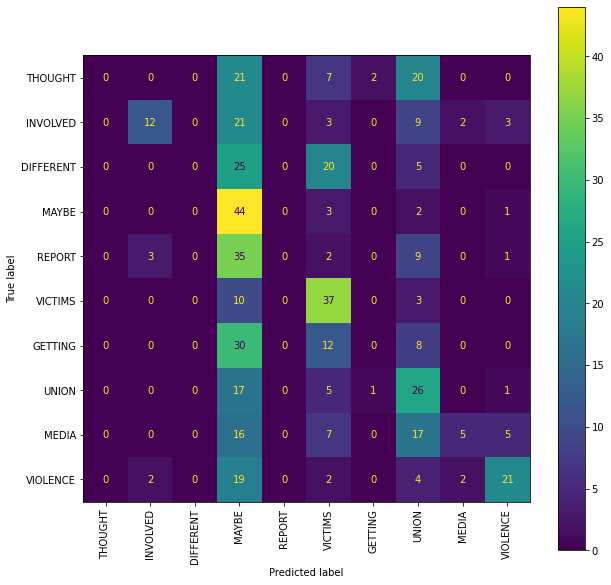

In [169]:
fig = plt.figure(figsize=(10, 10))
cm = confusion_matrix(testset.get_labels(), outputs)
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(cm,
                                    display_labels=data.keys()).plot(ax=ax,
                                                                       xticks_rotation="vertical")


# (Not useful for modelling) Some visualization

In [ ]:
def return_landmark_df(landmarks_array):
    landmarks_dict = {}
    order = 0
    for frame in landmarks_array:
        landmarks_dict[order] = pd.DataFrame(frame)
        order += 1
    return landmarks_dict

In [ ]:
landmarks_dict = return_landmark_df(landmarks_array)
landmarks_df = pd.concat(landmarks_dict)

In [ ]:
ax = landmarks_df.xs(36, level = 1).plot.scatter(1, 0)#, c = landmarks_df.index.get_level_values(0), title = filename)
for ind in np.arange(37, 42, 1):
    landmarks_df.xs(ind, level = 1).plot.scatter(1, 0, ax = ax)

In [ ]:
def visualize_one_landmark_flow(landmarks_array, filename = '', inOneGraph = True):
    for frame in landmarks_array:
        plt.scatter(frame[:, 1], frame[:, 0], )
        plt.title(filename)
        if not inOneGraph:
            plt.figure()

In [ ]:
visualize_one_landmark_flow(landmarks_array, filename)

In [ ]:
landmarks_array.shape

In [ ]:
visualize_one_landmark_flow(landmarks_array, inOneGraph=False)

## Using provided animation tool to generate short video

In [ ]:
any_video_path = 'datasets/jhmdb_dataset/videos/golf/Eric_Axley_golf_f_cm_np1_le_goo_0.avi'

In [ ]:
util.display_animation(any_video_path, landmarks_array, include_source_video = False)

In [ ]:
plt.scatter(landmarks_array[0][:, 0], -landmarks_array[0][:, 1]) 